<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. </b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [0, 1, 1, 0, 1]
y_predictions = [0.1, 0.9, 0.4, 0.6, 0.61]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
# Списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

np.nan не найдены:

In [5]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [6]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Однако есть пропуски в столбце TotalSpent, заменим их средним значением, а также приведем к типу float

In [7]:
(data == ' ').sum().sort_values(ascending=False)[:5]

TotalSpent            9
ClientPeriod          0
HasOnlineBackup       0
PaymentMethod         0
IsBillingPaperless    0
dtype: int64

In [8]:
data['TotalSpent'] = data['TotalSpent'].replace(to_replace=' ', value=np.nan).astype('float64')
data['TotalSpent'] = data['TotalSpent'].fillna(data['TotalSpent'].mean().round(2))

### Вывод: 
Nan'ы в данных отсуствуют. Однако были пропуски в столбце `TotalSpent`, которые были заменены на `mean`.

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

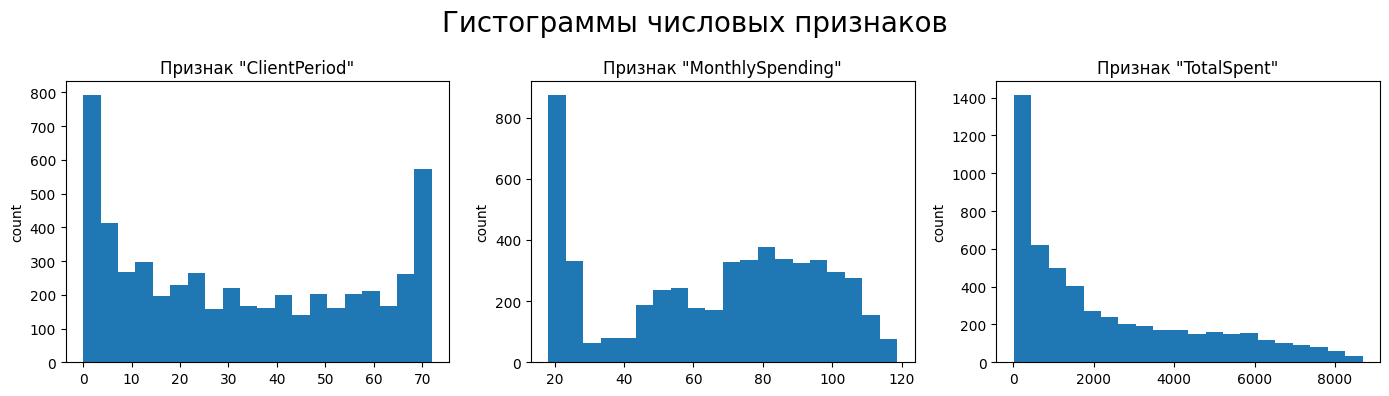

In [9]:
fig, axes = plt.subplots(ncols=len(num_cols), figsize=(14, 4))
fig.suptitle('Гистограммы числовых признаков', fontsize=20)
for i, col in enumerate(num_cols):
    axes[i].hist(data[col], bins=20)
    axes[i].set_title(f'Признак "{col}"')
    axes[i].set_ylabel('count')
plt.tight_layout()

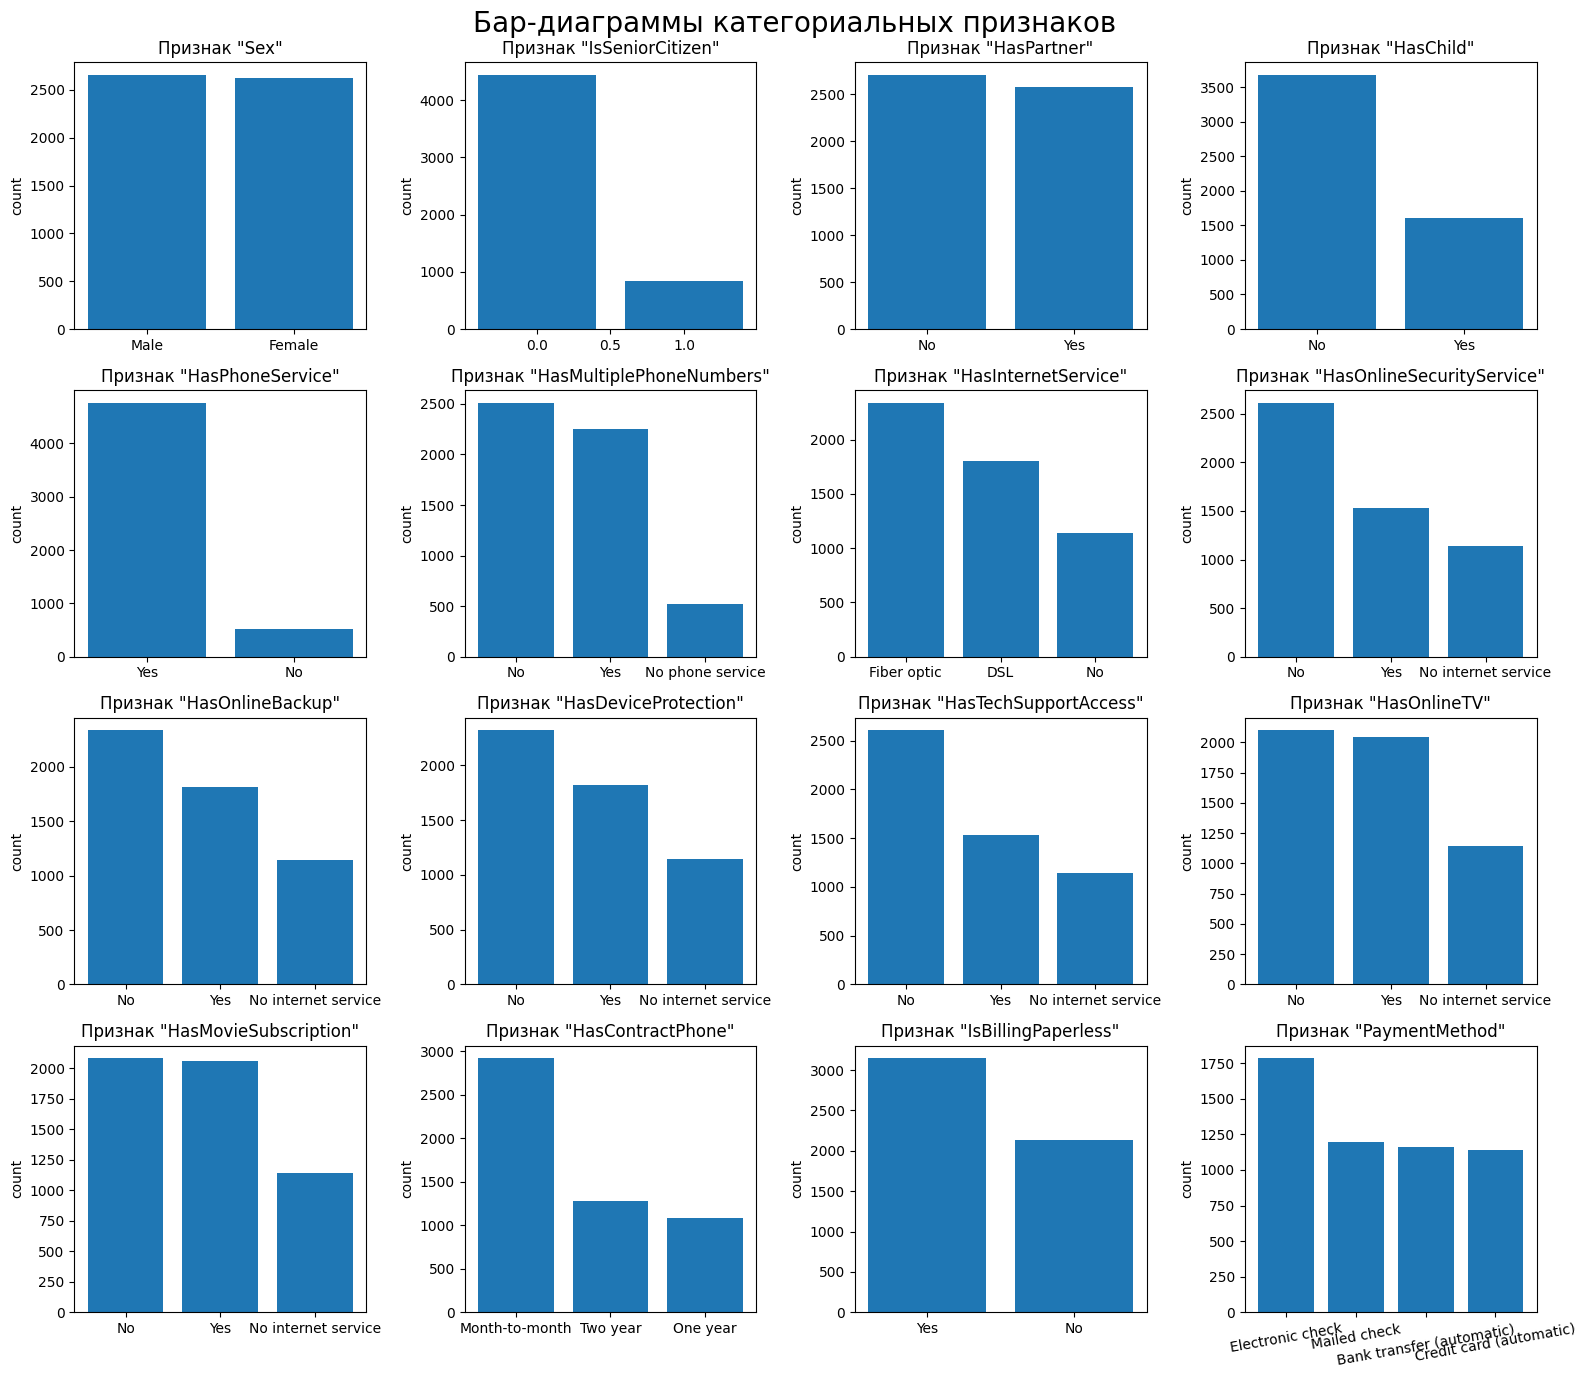

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 14))
fig.suptitle('Бар-диаграммы категориальных признаков', fontsize=20)
for i, col in enumerate(cat_cols):
    axes[i//4][i%4].bar(
        x=data[col].value_counts().index,
        height=data[col].value_counts()
    )
    axes[i//4][i%4].set_ylabel('count')
    axes[i//4][i%4].set_title(f'Признак "{col}"')
plt.xticks(rotation=10)
plt.tight_layout()

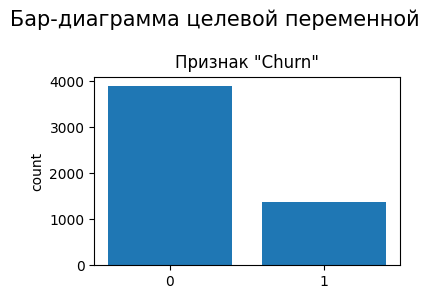

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))
fig.suptitle('Бар-диаграмма целевой переменной', fontsize=15)
ax.bar(x=data[target_col].value_counts().index, height=data[target_col].value_counts())
ax.set_title(f'Признак "{target_col}"')
ax.set_ylabel('count')
plt.xticks([0, 1])
plt.tight_layout()

#### Вывод: 
Каждый категориальный признак имеет 2, 3 или 4 значения. У целевой переменной преобладает значение 0, классы при классификации будут несбалансированны.  

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [14]:
# X, y
X = data.drop(columns=target_col, axis=0)
y = data[target_col]

# pipeline
ct = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), cat_cols),
    (StandardScaler(), num_cols)
)
my_pipeline = make_pipeline(ct, LogisticRegression(random_state=2))

# GridSearch
param_grid = {'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]}

cv_model = GridSearchCV(
    param_grid=param_grid, 
    estimator=my_pipeline,
    cv=5,
    scoring='roc_auc'
)

cv_model.fit(X, y)
cv_model.cv_results_

{'mean_fit_time': array([0.07478728, 0.10416098, 0.09156933, 0.07210436, 0.05204315,
        0.04553027]),
 'std_fit_time': array([0.01046284, 0.00699351, 0.0093599 , 0.00668177, 0.00561648,
        0.00600263]),
 'mean_score_time': array([0.01452451, 0.01443491, 0.01235209, 0.01176128, 0.01243391,
        0.01330104]),
 'std_score_time': array([0.0032878 , 0.00312845, 0.00028008, 0.00068933, 0.00037774,
        0.00317706]),
 'param_logisticregression__C': masked_array(data=[100, 10, 1, 0.1, 0.01, 0.001],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logisticregression__C': 100},
  {'logisticregression__C': 10},
  {'logisticregression__C': 1},
  {'logisticregression__C': 0.1},
  {'logisticregression__C': 0.01},
  {'logisticregression__C': 0.001}],
 'split0_test_score': array([0.8622466 , 0.8621494 , 0.8619689 , 0.86005276, 0.85573452,
        0.84912524]),
 'split1_test_score': array([0.83673517, 0.8366

In [15]:
# roc_auc для каждого 'C'
means = cv_model.cv_results_['mean_test_score']
means

array([0.84498878, 0.84496755, 0.84489618, 0.84400337, 0.84146541,
       0.83690206])

In [16]:
cv_model.best_estimator_[1]

LogisticRegression(C=100, random_state=2)

In [17]:
cv_model.best_score_

0.8449887780030633

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

#### Вывод: 
Используя pipeline, gridsearch для C, лучший параметр: C=100, лучшее качество получено на 1м фолде (0.845).

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [18]:
import catboost

# X, y
X = data.drop(columns=target_col, axis=0)
y = data[target_col]

# train-valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2)
print(X_train.shape, X_valid.shape)

(4225, 19) (1057, 19)


In [19]:
def get_best_boostmodel(X_train, y_train, X_valid, y_valid, lrs, n_estims):
    """
    Находим лучшие параметры для модели boostmodel по метрике roc-auc.
    Args:
        lrs: список из learing_rate,
        n_estims: список из n_etimators
    """
    valid_auc_best = 0
    lr_best = 0
    n_estim_best = 0
    
    for lr in lrs:
        for n_estim in n_estims:
            boost_model = catboost.CatBoostClassifier(
                cat_features=cat_cols,
                n_estimators=n_estim,
                learning_rate=lr, 
                random_state=2
            )
            boost_model.fit(X_train, y_train)
            y_valid_predicted = boost_model.predict_proba(X_valid)[:, 1]
            valid_auc = roc_auc_score(y_valid, y_valid_predicted)
            if valid_auc > valid_auc_best:
                valid_auc_best = valid_auc
                lr_best = lr
                n_estim_best = n_estim
    return n_estim_best, lr_best

In [20]:
lrs = [0.01, 0.03, 0.05]
n_estims = [100, 200, 300]

best_params = get_best_boostmodel(X_train, y_train, X_valid, y_valid, lrs, n_estims)

0:	learn: 0.6896403	total: 165ms	remaining: 16.3s
1:	learn: 0.6859341	total: 189ms	remaining: 9.25s
2:	learn: 0.6823287	total: 208ms	remaining: 6.73s
3:	learn: 0.6788414	total: 229ms	remaining: 5.5s
4:	learn: 0.6754004	total: 252ms	remaining: 4.79s
5:	learn: 0.6720965	total: 276ms	remaining: 4.32s
6:	learn: 0.6687783	total: 297ms	remaining: 3.95s
7:	learn: 0.6654747	total: 318ms	remaining: 3.66s
8:	learn: 0.6624323	total: 345ms	remaining: 3.49s
9:	learn: 0.6592097	total: 369ms	remaining: 3.32s
10:	learn: 0.6562587	total: 388ms	remaining: 3.14s
11:	learn: 0.6531326	total: 413ms	remaining: 3.02s
12:	learn: 0.6502749	total: 441ms	remaining: 2.95s
13:	learn: 0.6472841	total: 462ms	remaining: 2.84s
14:	learn: 0.6443497	total: 488ms	remaining: 2.76s
15:	learn: 0.6416068	total: 509ms	remaining: 2.67s
16:	learn: 0.6387332	total: 540ms	remaining: 2.64s
17:	learn: 0.6361949	total: 561ms	remaining: 2.56s
18:	learn: 0.6334228	total: 583ms	remaining: 2.48s
19:	learn: 0.6306890	total: 608ms	remainin

In [21]:
# лучшие параметры: n_estimators и learning_rate
best_params

(300, 0.03)

In [22]:
# обучение на лучших параметрах
boost_model_best = catboost.CatBoostClassifier(
    n_estimators=300, 
    learning_rate=0.03, 
    cat_features=cat_cols, 
    random_state=2
)
boost_model_best.fit(X_train, y_train)

y_train_predicted = boost_model_best.predict_proba(X_train)[:, 1]
y_valid_predicted = boost_model_best.predict_proba(X_valid)[:, 1]

0:	learn: 0.6734255	total: 32.2ms	remaining: 9.62s
1:	learn: 0.6559470	total: 62.6ms	remaining: 9.33s
2:	learn: 0.6412494	total: 109ms	remaining: 10.8s
3:	learn: 0.6261182	total: 146ms	remaining: 10.8s
4:	learn: 0.6127912	total: 182ms	remaining: 10.7s
5:	learn: 0.6013173	total: 196ms	remaining: 9.63s
6:	learn: 0.5884427	total: 229ms	remaining: 9.57s
7:	learn: 0.5764749	total: 260ms	remaining: 9.47s
8:	learn: 0.5651152	total: 296ms	remaining: 9.57s
9:	learn: 0.5556146	total: 326ms	remaining: 9.44s
10:	learn: 0.5462651	total: 357ms	remaining: 9.38s
11:	learn: 0.5379654	total: 385ms	remaining: 9.24s
12:	learn: 0.5304202	total: 416ms	remaining: 9.18s
13:	learn: 0.5238503	total: 446ms	remaining: 9.1s
14:	learn: 0.5166586	total: 479ms	remaining: 9.11s
15:	learn: 0.5104357	total: 510ms	remaining: 9.04s
16:	learn: 0.5045862	total: 538ms	remaining: 8.96s
17:	learn: 0.4999595	total: 559ms	remaining: 8.75s
18:	learn: 0.4944568	total: 592ms	remaining: 8.75s
19:	learn: 0.4894440	total: 629ms	remain

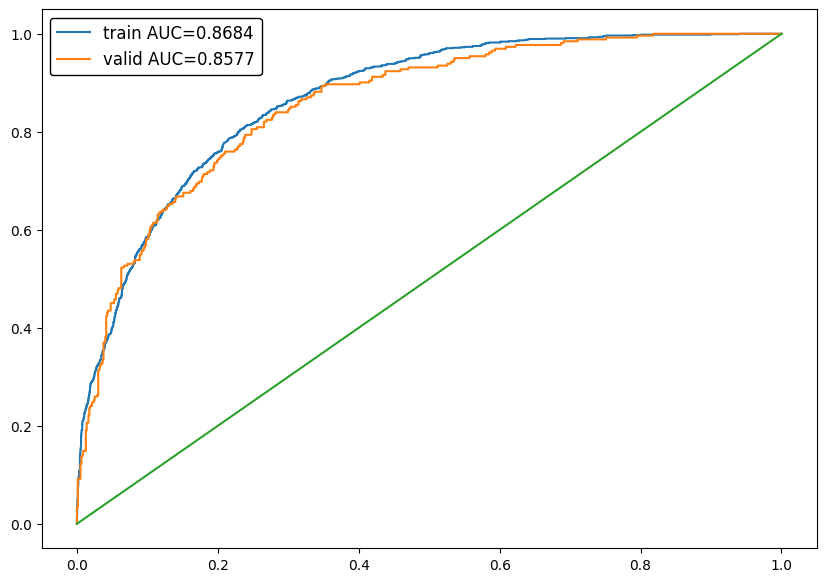

In [23]:
# считаем auc
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

# отрисовываем график
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [24]:
valid_auc 

0.8577200057611983

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

#### Вывод: 
Лучшее качество = 0.8577. Его удалось получить на следующих параметрах: lr=0.03, n_estimators=300.

# Предсказания

In [25]:
best_model = boost_model_best

In [27]:
best_model.predict_proba(X_test) 

array([[0.95119992, 0.04880008],
       [0.3239712 , 0.6760288 ],
       [0.32007123, 0.67992877],
       ...,
       [0.18974181, 0.81025819],
       [0.41646522, 0.58353478],
       [0.98888943, 0.01111057]])

In [28]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv').set_index('Id')
submission

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', columns=['Churn'])
submission

,Churn
Id,
0,0.048800
1,0.676029
2,0.679929
3,0.013568
4,0.004613
...,...
1756,0.144630
1757,0.011122
1758,0.810258
